In [6]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras import optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM, GRU, TimeDistributed
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, MaxPool2D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd
import random
from service.data_augmentation import make_batch

In [7]:
df_target = pd.read_csv(os.path.abspath('Target_words_dataframe'))
df_unknown = pd.read_csv(os.path.abspath('Unknown_words_dataframe'))
df = pd.read_csv(os.path.abspath('full_df'))

In [8]:
df_target = df_target.drop(columns=['Unnamed: 0'], axis=1)
df_unknown = df_unknown.drop(columns=['Unnamed: 0'], axis=1)

In [9]:
df

,Unnamed: 0,word,path
0,0,yes,/Users/mbassalaev/Desktop/spotter_data/yes/988...
1,1,yes,/Users/mbassalaev/Desktop/spotter_data/yes/93e...
2,2,yes,/Users/mbassalaev/Desktop/spotter_data/yes/a75...
3,3,yes,/Users/mbassalaev/Desktop/spotter_data/yes/627...
4,4,yes,/Users/mbassalaev/Desktop/spotter_data/yes/439...
...,...,...,...
64716,41034,unkown,/Users/mbassalaev/Desktop/spotter_data/four/93...
64717,41035,unkown,/Users/mbassalaev/Desktop/spotter_data/four/0c...
64718,41036,unkown,/Users/mbassalaev/Desktop/spotter_data/four/23...
64719,41037,unkown,/Users/mbassalaev/Desktop/spotter_data/four/17...


In [10]:
filename = os.path.abspath('../../Data_spotter_mfcc_40')
outfile = open(filename,'rb')
X = pickle.load(outfile)
outfile.close()

In [11]:
def save_model(Model, model_name):
    save_dir = os.path.join(os.getcwd(), 'saved_models')

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    Model.save(model_path)
    print('Save model and weights at %s ' % model_path)

    model_json = Model.to_json()
    with open("model_json.json", "w") as json_file:
        json_file.write(model_json)

In [12]:
def save_model_history(model_history, model_history_name):
    filename = 'saved_models_history/' + model_history_name
    outfile = open(filename,'wb')
    pickle.dump(model_history, outfile)
    outfile.close()

In [13]:
def report(model, X, y, classes):
    model_predictions = model.predict(X).argmax(axis=1)
    true_predictions = y.argmax(axis=1)
    return sklearn.metrics.classification_report(true_predictions, model_predictions, target_names=classes)

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X
                                                    , df.word
                                                    , test_size=6464
                                                    , train_size = 58240
                                                    , shuffle=True
                                                    , random_state=42)

In [15]:
print(f'X_train size = {X_train.shape}')
print(f'Y_train size = {Y_train.shape}')
print(f'X_test size = {X_test.shape}')
print(f'Y_test size = {Y_test.shape}')

X_train size = (58240, 40, 61)
Y_train size = (58240,)
X_test size = (6464, 40, 61)
Y_test size = (6464,)


In [16]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [17]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [18]:
lb = LabelEncoder()
Y_train = np_utils.to_categorical(lb.fit_transform(Y_train))
Y_test = np_utils.to_categorical(lb.fit_transform(Y_test))
print('classes = ', lb.classes_)

classes =  ['down' 'go' 'left' 'no' 'off' 'on' 'right' 'stop' 'unkown' 'up' 'yes']


In [126]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
print(f'X_train size = {X_train.shape}')
print(f'X_test size = {X_test.shape}')
print(f'Y_train size = {Y_train.shape}')
print(f'Y_test size = {Y_test.shape}')

X_train size = (58240, 40, 61, 1)
X_test size = (6464, 40, 61, 1)
Y_train size = (58240, 11)
Y_test size = (6464, 11)


In [127]:
def CRNN_model(input_shape, nclass):
    
    input_ = Input(input_shape, batch_size=64)
    
    X = Conv2D(16, kernel_size=(3, 3), activation="relu", dilation_rate=(1, 1), strides=(1, 1))(input_)
    X = Conv2D(16, kernel_size=(5, 3), activation="relu", dilation_rate=(1, 1), strides=(1, 1))(X)
    
    shape = X.shape
    X = tf.keras.layers.Reshape((-1, shape[2] * shape[3]))(X)
    
    X = GRU(units = 256, return_sequences=0, stateful=1)(X)
    
    X = Flatten()(X)
    X = Dropout(rate=0.1)(X)
    
    X = Dense(128, activation="linear")(X)
    X = Dense(256, activation="relu")(X)
    
    output_ = Dense(nclass, activation='softmax')(X)
    
    ret_model = Model(inputs = input_, outputs=output_)
    
    return ret_model

In [128]:
model = CRNN_model((40, 61, 1), len(lb.classes_))

11

In [129]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(64, 40, 61, 1)]         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (64, 38, 59, 16)          160       
_________________________________________________________________
conv2d_38 (Conv2D)           (64, 34, 57, 16)          3856      
_________________________________________________________________
reshape_7 (Reshape)          (64, 34, 912)             0         
_________________________________________________________________
gru_17 (GRU)                 (64, 256)                 898560    
_________________________________________________________________
flatten_6 (Flatten)          (64, 256)                 0         
_________________________________________________________________
dropout_6 (Dropout)          (64, 256)                 0   

In [130]:
opt = optimizers.Adam(0.001)
model.compile(optimizer = opt, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics = ["accuracy"])

In [131]:
batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
val_dataset = val_dataset.batch(batch_size)

loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)
train_acc_metric = keras.metrics.CategoricalAccuracy()

In [132]:
epochs = 3

test_loss = []
test_acc = []
train_loss = []
train_acc = []

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        opt.apply_gradients(zip(grads, model.trainable_weights))
        
        train_acc_metric.update_state(y_batch_train, logits)
        # Log every 50 batches.
        if step % 50 == 0 and step > 0:
            test_loss_acc = model.evaluate(X_test, Y_test, batch_size=64)
            train_loss_acc = float(loss_value), float(train_acc_metric.result()) 
            test_loss.append(test_loss_acc[0])
            test_acc.append(test_loss_acc[1])
            train_loss.append(train_loss_acc[0])
            train_acc.append(train_loss_acc[1])
            print("Current step: %d" % step)
            print("Test loss and acc: %.4f %.4f" % (test_loss_acc[0], test_loss_acc[1]))
            print("Training loss and acc: %.4f %.4f" % (float(train_loss_acc[0]), float(train_loss_acc[1])))
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
    train_acc_metric.reset_states()


Start of epoch 0
101/101 [==============================] - 5s 42ms/step - loss: 1.5050 - accuracy: 0.6425
Current step: 50
Test loss and acc: 1.5449 0.6303
Training loss and acc: 1.7412 0.6486
Seen so far: 3264 samples
101/101 [==============================] - 4s 42ms/step - loss: 1.5096 - accuracy: 0.6303
Current step: 100
Test loss and acc: 1.5096 0.6303
Training loss and acc: 1.3888 0.6463
Seen so far: 6464 samples
101/101 [==============================] - 4s 42ms/step - loss: 1.5472 - accuracy: 0.6303
Current step: 150
Test loss and acc: 1.5472 0.6303
Training loss and acc: 1.5103 0.6448
Seen so far: 9664 samples
101/101 [==============================] - 4s 42ms/step - loss: 1.4971 - accuracy: 0.6303
Current step: 200
Test loss and acc: 1.4971 0.6303
Training loss and acc: 1.3139 0.6395
Seen so far: 12864 samples
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it 

In [133]:
epochs = 3

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        opt.apply_gradients(zip(grads, model.trainable_weights))
        
        train_acc_metric.update_state(y_batch_train, logits)
        # Log every 50 batches.
        if step % 50 == 0 and step > 0:
            test_loss_acc = model.evaluate(X_test, Y_test, batch_size=64)
            train_loss_acc = float(loss_value), float(train_acc_metric.result()) 
            test_loss.append(test_loss_acc[0])
            test_acc.append(test_loss_acc[1])
            train_loss.append(train_loss_acc[0])
            train_acc.append(train_loss_acc[1])
            print("Current step: %d" % step)
            print("Test loss and acc: %.4f %.4f" % (test_loss_acc[0], test_loss_acc[1]))
            print("Training loss and acc: %.4f %.4f" % (float(train_loss_acc[0]), float(train_loss_acc[1])))
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
    train_acc_metric.reset_states()


Start of epoch 0
101/101 [==============================] - 5s 45ms/step - loss: 0.7573 - accuracy: 0.7534
Current step: 50
Test loss and acc: 0.7573 0.7534
Training loss and acc: 0.7065 0.7840
Seen so far: 3264 samples
101/101 [==============================] - 4s 42ms/step - loss: 0.7090 - accuracy: 0.7658
Current step: 100
Test loss and acc: 0.7090 0.7658
Training loss and acc: 0.4645 0.7856
Seen so far: 6464 samples
101/101 [==============================] - 4s 43ms/step - loss: 0.7061 - accuracy: 0.7686
Current step: 150
Test loss and acc: 0.7061 0.7686
Training loss and acc: 0.8381 0.7827
Seen so far: 9664 samples
101/101 [==============================] - 4s 42ms/step - loss: 0.7293 - accuracy: 0.7628
Current step: 200
Test loss and acc: 0.7293 0.7628
Training loss and acc: 0.5748 0.7849
Seen so far: 12864 samples
101/101 [==============================] - 4s 42ms/step - loss: 0.7865 - accuracy: 0.7539
Current step: 250
Test loss and acc: 0.7865 0.7539
Training loss and acc: 0.

In [134]:
epochs = 3

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        opt.apply_gradients(zip(grads, model.trainable_weights))
        
        train_acc_metric.update_state(y_batch_train, logits)
        # Log every 50 batches.
        if step % 50 == 0 and step > 0:
            test_loss_acc = model.evaluate(X_test, Y_test, batch_size=64)
            train_loss_acc = float(loss_value), float(train_acc_metric.result()) 
            test_loss.append(test_loss_acc[0])
            test_acc.append(test_loss_acc[1])
            train_loss.append(train_loss_acc[0])
            train_acc.append(train_loss_acc[1])
            print("Current step: %d" % step)
            print("Test loss and acc: %.4f %.4f" % (test_loss_acc[0], test_loss_acc[1]))
            print("Training loss and acc: %.4f %.4f" % (float(train_loss_acc[0]), float(train_loss_acc[1])))
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
    train_acc_metric.reset_states()


Start of epoch 0
101/101 [==============================] - 4s 42ms/step - loss: 0.7180 - accuracy: 0.7984
Current step: 50
Test loss and acc: 0.7180 0.7984
Training loss and acc: 0.3736 0.9056
Seen so far: 3264 samples
101/101 [==============================] - 4s 42ms/step - loss: 0.8028 - accuracy: 0.7867
Current step: 100
Test loss and acc: 0.8028 0.7867
Training loss and acc: 0.4694 0.9083
Seen so far: 6464 samples
101/101 [==============================] - 4s 41ms/step - loss: 0.7168 - accuracy: 0.8014
Current step: 150
Test loss and acc: 0.7168 0.8014
Training loss and acc: 0.2807 0.9087
Seen so far: 9664 samples
101/101 [==============================] - 4s 42ms/step - loss: 0.7518 - accuracy: 0.8021
Current step: 200
Test loss and acc: 0.7518 0.8021
Training loss and acc: 0.1394 0.9106
Seen so far: 12864 samples
101/101 [==============================] - 4s 41ms/step - loss: 0.7628 - accuracy: 0.7922
Current step: 250
Test loss and acc: 0.7628 0.7922
Training loss and acc: 0.

In [22]:
save_model(model, "CRNN")

INFO:tensorflow:Assets written to: C:\Users\Mi Notebook\Desktop\Audio_project\audio_project\Spotter_recognition\saved_models\CRNN\assets
Save model and weights at C:\Users\Mi Notebook\Desktop\Audio_project\audio_project\Spotter_recognition\saved_models\CRNN 


In [23]:
save_model_history(model_history.history, "CRNN")

In [140]:
temp = np.arange(50, 8150, 50)

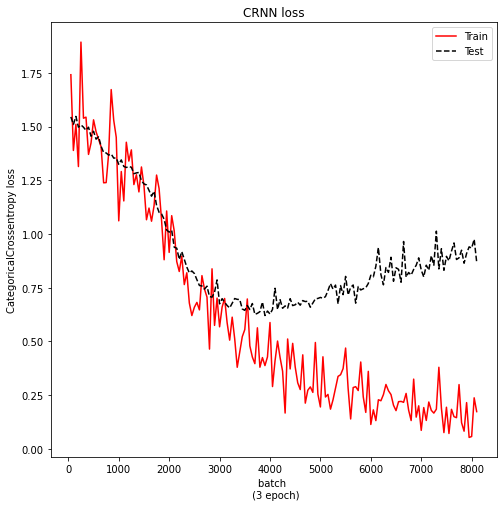

In [142]:
plt.figure(figsize=(8,8))
train_plot = plt.plot(temp, train_loss, color='red', label='Train')
test_plot = plt.plot(temp, test_loss, color='black', linestyle='dashed', label='Test')
plt.title('CRNN loss')
plt.ylabel('CategoricalCrossentropy loss')
plt.xlabel('batch \n (3 epoch)')
plt.legend(loc='upper right')
#plt.savefig("CRNN_withou_spec_auc")
plt.show()

In [29]:
print(report(model, X_test, Y_test, lb.classes_))

              precision    recall  f1-score   support

        down       0.87      0.78      0.82       254
          go       0.93      0.83      0.88       229
        left       0.90      0.81      0.86       236
          no       0.87      0.75      0.81       242
         off       0.86      0.80      0.83       226
          on       0.83      0.77      0.80       229
       right       0.89      0.81      0.85       252
        stop       0.95      0.84      0.89       235
     unknown       0.92      0.97      0.95      4081
          up       0.89      0.78      0.84       250
         yes       0.98      0.89      0.93       239

    accuracy                           0.91      6473
   macro avg       0.90      0.82      0.86      6473
weighted avg       0.91      0.91      0.91      6473

